In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [14]:
tool_dict = {'DiamondMegan_filtered':'DiamondMegan',
             'CLARK':'ClarkM1Default',
             'CLARK-S':'ClarkM4Spaced',
             'Kraken':'Kraken', 
             'Kraken_filtered':'KrakenFiltered',
             'PhyloSift':'PhyloSift',
             'PhyloSift_filtered':'PhyloSift90pct',
             'MetaPhlAn':'Metaphlan',
             'LMAT':'LMAT',
             'GOTTCHA':'Gottcha',
             'MetaFlow':'MetaFlow',
             #'Community':'COMMUNITY',
             'BlastEnsemble':'blastensemble-priority',
             'DiamondEnsemble':'diamondensemble-priority',
             #'DiamondMegan_filtered+Kraken_filtered':'DiamondMeganKrakenFiltered',
             #'BlastMegan_filtered+LMAT':'BlastMeganFilteredLMAT',
             #'CLARK+GOTTCHA':'ClarkM1DefaultGottcha',
             'BlastMegan_filtered':'BlastMeganFiltered',
             'BlastMegan_filtered_liberal':'BlastMeganFilteredLiberal',
             #'NBC':'NBC',
             }

In [2]:
colour_dict = {
             'BlastMegan_filtered':(166,206,227),
             'BlastMegan_filtered_liberal':(31,120,180),
             'CLARK':(178,223,138),
             'CLARK-S':(51,160,44),
             'DiamondMegan_filtered':(190,190,190),
             'GOTTCHA':(106,61,154),
             'Kraken':(255,127,0), 
             'Kraken_filtered':(253,191,111),
             'LMAT':(176,48,96),
             'MetaFlow':(177,89,40),
             'MetaPhlAn':(148,0,211),
             #'NBC':(255,0,255),
             'PhyloSift':(102,205,0),
             'PhyloSift_filtered':(127,255,0),
             'Community':(0,0,0),
             #'BlastMegan_filtered+LMAT':(33,160,160),
             #'CLARK+GOTTCHA':(255,233,0),
             #'DiamondMegan_filtered+Kraken_filtered':(202,178,214),
             'BlastEnsemble':(251,154,153),
             'DiamondEnsemble':(227,26,28)}
for tool in colour_dict:
    colour_dict[tool] = tuple(map(lambda x: x/255., colour_dict[tool]))

In [6]:
def tabulate(fi1,index,abundance_threshold=0):   
    fi = open(fi1).read().split('\n')
    di = {line.split()[0]:float(line.split()[index]) for line in fi
        if len(line.split()) > 3 and line.split()[index] != '' and float(line.split()[2])>abundance_threshold} 
    df = pd.DataFrame(di.items(), columns=['taxid', 'num']) 
    return df

In [7]:
read_cats= {'small':['5','10','15'],'med':['20','30','40'],'large':['50','75','100']}
full_df = pd.DataFrame()
for tool in tool_dict:
    for category in read_cats:
        for num_reads in read_cats[category]:
            try: 
                dataset_df = tabulate('species/Downsample_Deep.'+num_reads+'.Mreads_'+tool_dict[tool]+'.txt',2)
                dataset_df['category'] = category
                dataset_df['num_reads'] = int(num_reads)
                dataset_df['tool'] = tool
                dataset_df['num'] = dataset_df['num']*100
                full_df = full_df.append(dataset_df)
            except IOError:
                print tool, num_reads

In [130]:
variance_df = pd.DataFrame()
for tool in set(full_df.tool):
    tool_df = full_df[full_df.tool == tool]
    for taxid in set(tool_df.taxid):
        taxid_df = tool_df[tool_df.taxid == taxid]
        if len(taxid_df) == len(sum(read_cats.values(),[])): #ie. number of downsampled files
            cat_dict = {'category':[],'variance':[]}
            for cat in read_cats:
                cat_df = taxid_df[taxid_df.category == cat]
                cat_dict['category'].append(cat)
                cat_dict['variance'].append(np.var(cat_df.num))
            tax_df = pd.DataFrame(cat_dict)
            tax_df['tool'] = tool
            variance_df = variance_df.append(tax_df)

KeyboardInterrupt: 

In [45]:
variance_df.head()

,category,variance,tool
0,small,2.222222e-11,PhyloSift_filtered
1,med,7.346840e-40,PhyloSift_filtered
2,large,7.346840e-40,PhyloSift_filtered
0,small,2.222222e-09,PhyloSift_filtered
1,med,0.000000e+00,PhyloSift_filtered


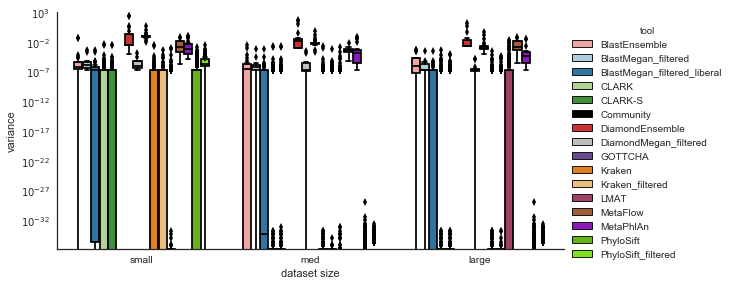

In [84]:
#with sns.plotting_context(font_scale=fs):
fig = plt.figure(figsize=(5,10))
sns.set_style('white')
sns.set_palette([colour_dict[tool] for tool in sorted(colour_dict.keys())])
g = sns.factorplot(x='category',y='variance',hue='tool',data=variance_df,kind='box',hue_order=sorted(colour_dict.keys()),aspect=2,legend=True)   
g.fig.get_axes()[0].set_yscale('log')
plt.ylim([0,1000])     
plt.xlabel('dataset size')

In [95]:
xtool_variance_df[xtool_variance_df.variance > 0.00001]

,category,variance
0,large,0.000025


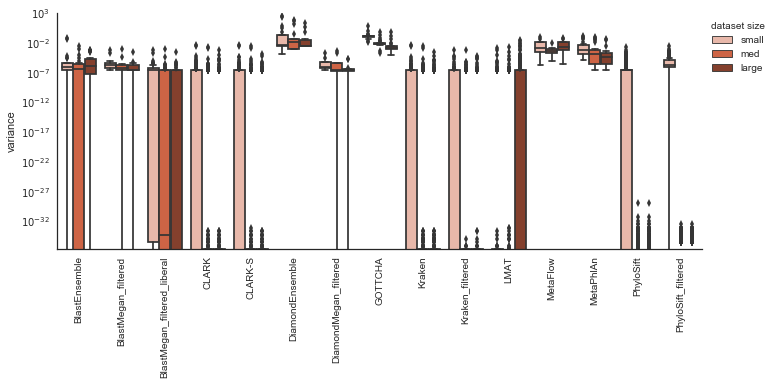

In [87]:
fig = plt.figure(figsize=(5,10))
sns.set_style('white')
sns.set_palette(['#F2B2A0','#E4572E','#92381E'])
g = sns.factorplot(x='tool',y='variance',hue='category',data=variance_df.sort_values('tool'),kind='box',hue_order=['small','med','large'],aspect=2.5,legend=False)   
g.fig.get_axes()[0].set_yscale('log')
plt.ylim([0,1000])     
plt.xticks(rotation=90)
plt.xlabel('')
plt.legend(bbox_to_anchor=(1, 1), loc=2 ,title='dataset size')

In [20]:
#variances across tools at specific numbers of reads for 
xtool_variance_df = pd.DataFrame()
for cat in set(full_df.category):
    cat_df = full_df[full_df.category == cat]
    for taxid in set(cat_df.taxid):
        taxid_df = cat_df[cat_df.taxid == taxid]
        tool_dic = {'variance':[],'num':[]}
        for num in read_cats[cat]:
            num_df = taxid_df[taxid_df.num_reads == int(num)]
            #for species found by >= 5 tools
            if len(set(num_df.tool)) >= 12: 
                #print taxid
                tool_dic['variance'].append(np.var(num_df.num))
                tool_dic['num'].append(int(num))
        tax_df = pd.DataFrame(tool_dic)
        tax_df['category'] = cat
        tax_df['taxid'] = taxid
        xtool_variance_df = xtool_variance_df.append(tax_df)


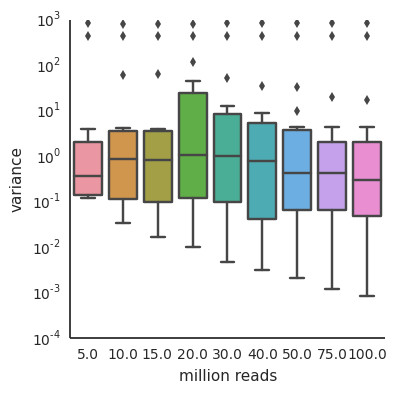

In [21]:
fig = plt.figure(figsize=(5,5))
sns.set_style('white')
#sns.set_palette(['#F2B2A0','#E4572E','#92381E'])
g = sns.factorplot(x='num',y='variance',data=xtool_variance_df.sort_values('num'),kind='box',aspect=1,legend=False)   
g.fig.get_axes()[0].set_yscale('log')
#plt.ylim([0,1000])     
#plt.xticks(rotation=90)
plt.xlabel('million reads')
plt.legend(bbox_to_anchor=(1, 1), loc=2 ,title='dataset size')

In [129]:
xtool_variance_df

,num,variance,category,taxid
0,5.0,0.000659,small,290399
1,10.0,0.000659,small,290399
2,15.0,0.000654,small,290399
0,5.0,0.413399,small,550
1,10.0,0.416779,small,550
2,15.0,0.376127,small,550
0,5.0,1.156974,small,29385
1,10.0,0.704957,small,29385
2,15.0,0.565204,small,29385
0,5.0,0.355361,small,1280


In [19]:
set(full_df[full_df.tool == 'Community'].taxid)

set()